# STA2453 - Data Science Methods, Collaboration, and Communication

# Credit Card Fraud Detection

### Team -
#### Pulkit Mathur
#### Angad Kalra
#### Shaung

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
data = pd.read_csv('credit_card_fraud_data_v2.csv')
data.head()

,Time_Stamp,Transaction_Type,Amount,Client_Id,Client_Old_Balance,Cleint_New_Balance,Merchant_Id,Merchant_Old_Balance,Merchant_New_Balance,Is_Fraud,Is_Flagged_Fraud
0,1,BILL-PAYMENT,9839.64,C494672677,170136.0,160296.36,M582455116,0.0,0.0,0,0
1,1,BILL-PAYMENT,1864.28,C502607876,21249.0,19384.72,C214000796,0.0,0.0,0,0
2,1,PURCHASE,181.00,C633112680,181.0,0.00,M1922059099,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C1993768127,181.0,0.00,M245426835,21182.0,0.0,1,0
4,1,BILL-PAYMENT,11668.14,C1445837831,41554.0,29885.86,M1368211346,0.0,0.0,0,0


## Exploratory Data Analysis

##### Data Imbalance

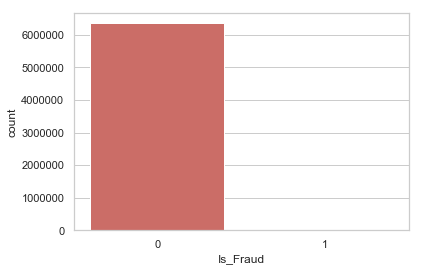

In [3]:
sns.countplot(x='Is_Fraud',data=data, palette='hls')
plt.show()

In [4]:
Count_Fraud_transacation = len(data[data['Is_Fraud']==1])
print("Number of fraud transactions-",Count_Fraud_transacation)
Count_Normal_transacation = len(data[data['Is_Fraud']==0])
print("Number of non-fraud transactions-",Count_Normal_transacation)
Percentage_of_Fraud_transacation= Count_Fraud_transacation/(Count_Normal_transacation+Count_Fraud_transacation)
print("Percentage of fraud transacation",Percentage_of_Fraud_transacation*100)

Number of fraud transactions- 18213
Number of non-fraud transactions- 6354407
Percentage of fraud transacation 0.2858008166185964


Distributions: By seeing the distributions we can have an idea how skewed are these features are. There are techniques that can help the distributions be less skewed. Let's try them !!

##### Random- Under Sampling
This method consists of removing data in order to have a more balanced dataset and thus avoiding the model to overfit.

Steps:

1) Determine how imbalanced is our class is.

2) Once we determine how many instances are considered fraud transactions (Fraud = "1") , we should bring the non-fraud transactions to the same amount as fraud transactions (assuming we want a 50/50 ratio), this will be equivalent to 492 cases of fraud and 18213 cases of non-fraud transactions.

3) After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to shuffle the data to see if our models can maintain a certain accuracy everytime we run this script.

Note: The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of information loss (bringing 18213 non-fraud transaction from 6354407 non-fraud transaction)

In [6]:
# Shuffle the data before creating the subsamples

data = data.sample(frac=1)

# amount of fraud classes 18213 rows.
fraud_df = data.loc[data['Is_Fraud'] == 1]
non_fraud_df = data.loc[data['Is_Fraud'] == 0][:18213]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=14)

new_df.head()

,Time_Stamp,Transaction_Type,Amount,Client_Id,Client_Old_Balance,Cleint_New_Balance,Merchant_Id,Merchant_Old_Balance,Merchant_New_Balance,Is_Fraud,Is_Flagged_Fraud
6065296,510,PURCHASE,3178881.71,C1338468864,3178881.71,0.00,C603795198,0.00,0.00,1,0
6364961,33,PURCHASE,1448630.38,C1084150990,1448630.38,0.00,C1409891653,0.00,0.00,1,0
6362802,425,CASH_OUT,10000000.00,C2043772409,10000000.00,0.00,M1597247232,10662599.15,20662599.15,1,0
6364762,425,CASH_OUT,10000000.00,C2043772409,10000000.00,0.00,M1597247232,10662599.15,20662599.15,1,0
5473192,379,BILL-PAYMENT,1088.34,C566509240,12641.78,11553.44,M864287103,0.00,0.00,0,0


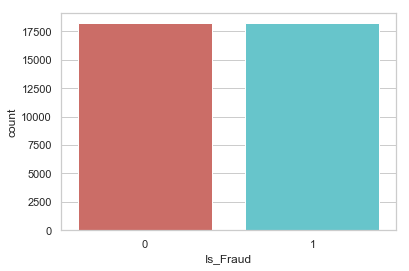

In [7]:
sns.countplot(x='Is_Fraud',data=new_df, palette='hls')
plt.show()